<h3>Principais libs utilizadas</h3>

In [1]:
import seaborn as sn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os
from sklearn import metrics
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import seaborn as sns

# define dark background pros graficos
plt.style.use('dark_background')
sns.color_palette()[0]

(0.5529411764705883, 0.8274509803921568, 0.7803921568627451)

<h3>Importa-se os dados formatados em csv com colunas correspondentes e seta variáveis globais</h3>

In [2]:
from os.path import abspath
# leitura dos dados
data = pd.read_csv(abspath('./data/haberman.csv'))

# folds
n_folds=30

scoring='accuracy'
cv = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=3,
random_state=1)

GRAPHS_PATH = os.path.join(abspath('./graphs/'))

os.makedirs(GRAPHS_PATH, exist_ok=True)


<h3>Retorna métricas para o teste</h3>

In [3]:
def metric(test,predict):
    mcc=metrics.matthews_corrcoef(test,predict)
    acc=metrics.accuracy_score(test,predict)
    p=metrics.precision_score(test,predict)
    r=metrics.recall_score(test,predict)
    f1=metrics.f1_score(test,predict)
    name={}
    name = dict(zip(['ACC','MCC','R','P','F'], [acc,mcc,r,p,f1]))
    return name


<h3>Retorna a matrix de confusão para o teste</h3>

In [4]:
def confusion_matrix(test,predict):
    cm = pd.crosstab(test, predict, rownames=['Real'],
    colnames=['Predict'])
    return cm

<h3>Gera os heatmaps para o teste</h3>

In [5]:
def mc_heatmap(original,graph_name,best):
    if(best is not None):
        fig, (ax1, ax2) = plt.subplots(1,2)
        sn.heatmap(original, ax=ax1,annot=True)
        ax1.title.set_text('First model')
        sn.heatmap(best, ax=ax2,annot=True)
        ax2.title.set_text('Best model')
        fig.set_size_inches(10,4)
    else:
        sn.heatmap(original,annot=True)
        plt.title('Original model')
            
    plt.savefig(os.path.join(GRAPHS_PATH, graph_name+'.png'))
    plt.show()


<h3>O teste de Shapiro para detectar distribuições normais pode ser dado como:</h3>

In [6]:
def shapiro_test(col):
    n=data.columns.get_loc(col)
    sp = stats.shapiro(data.iloc[:,n])
    est = sp.statistic
    pvalor = sp.pvalue
    if pvalor > 0.05:
        dist_type='Normal distribution'
    else:
        dist_type='Non normal distribution'
    shap_test = dict(zip(['estat','pvalue','dist_type'], [est,
    pvalor,dist_type]))
    print(f'{col} p-value {pvalor:,.5f}, then the distribution is {dist_type}.')
    return shap_test

<h3>Análise com os modelos - Divisão de database e demais etapas iniciais da análise</h3>

In [7]:
#dataframe size
print('\nDataframe size: {} lines'.format(data.shape[0]))
# dataframe columns
print('\nDataframe columns: {}\n'.format(data.columns))
# dataframe analysis variables
X = data.iloc[:,:-1]
# dataframe response variable
Y = data['survival']

# Shapiro test for each column
shap_age = shapiro_test('age')
shap_year = shapiro_test('year')
shap_nodes = shapiro_test('nodes')
shap_survival = shapiro_test('survival')

#Model divided in two groups:
np.random.seed(7)
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,
random_state=0)

#Models created
models = []
models.append(('LR', LogisticRegression(solver='newton-cg')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))

# Initial evaluation of models with training set
results = []
names = []
for name, model in models:
    cv_results = cross_val_score(model, x_train.values, y_train.values,
    cv=cv, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


Dataframe size: 306 lines

Dataframe columns: Index(['age', 'year', 'nodes', 'survival'], dtype='object')

age p-value 0.02606, then the distribution is Non normal distribution.
year p-value 0.00000, then the distribution is Non normal distribution.
nodes p-value 0.00000, then the distribution is Non normal distribution.
survival p-value 0.00000, then the distribution is Non normal distribution.
LR: 0.774603 (0.122613)
LDA: 0.785516 (0.123847)
KNN: 0.766865 (0.122895)
CART: 0.681746 (0.154500)
NB: 0.790278 (0.123763)


<h3>1 - Regressão Logistica (LR)</h3>

{'ACC': 0.6304347826086957, 'MCC': 0.04028297472553804, 'R': 0.9827586206896551, 'P': 0.6333333333333333, 'F': 0.7702702702702702}


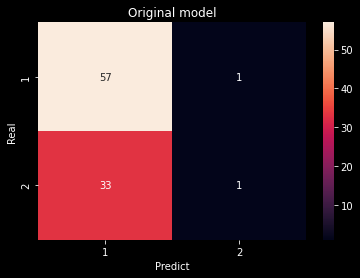

In [8]:
logistic_regression=LogisticRegression()
logistic_regression.fit(x_train,y_train)
y_pred_lr=logistic_regression.predict(x_test)

#Confusion matrix
LR_MC = confusion_matrix(y_test,y_pred_lr)

# metrics
LR_METRICS = metric(y_test,y_pred_lr)
print(LR_METRICS)
mc_heatmap(LR_MC, 'LR_MC', None)


<h3>2 - Análise Discriminante (LDA)</h3>

{'ACC': 0.6413043478260869, 'MCC': 0.11444788768107905, 'R': 0.9655172413793104, 'P': 0.6436781609195402, 'F': 0.7724137931034483}


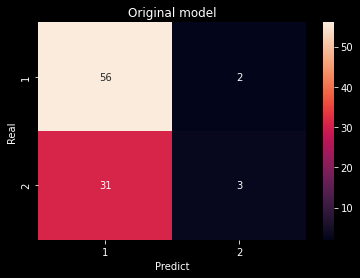

In [9]:
discriminant_analysis=LinearDiscriminantAnalysis()
discriminant_analysis.fit(x_train,y_train)
y_pred_lda=discriminant_analysis.predict(x_test)

# Confusion matrix
LDA_MC = confusion_matrix(y_test,y_pred_lda)

# Metrics
LDA_METRICS = metric(y_test,y_pred_lda)
print(LDA_METRICS)
mc_heatmap(LDA_MC, 'LDA_MC', None)


<h3>3 - Árvore de Decisão (CART)</h3>

{'ACC': 0.6086956521739131, 'MCC': 0.11959432824953069, 'R': 0.7586206896551724, 'P': 0.6666666666666666, 'F': 0.7096774193548386}
Fitting 30 folds for each of 50 candidates, totalling 1500 fits
{'ACC': 0.6304347826086957, 'MCC': 0.16053840922847368, 'R': 0.7931034482758621, 'P': 0.6764705882352942, 'F': 0.7301587301587301}


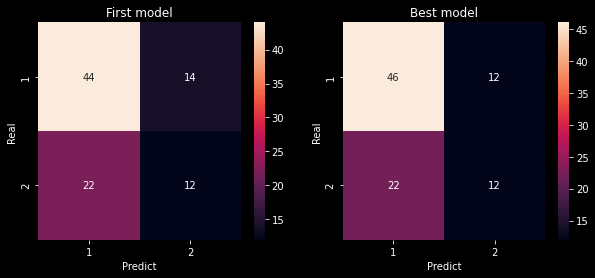

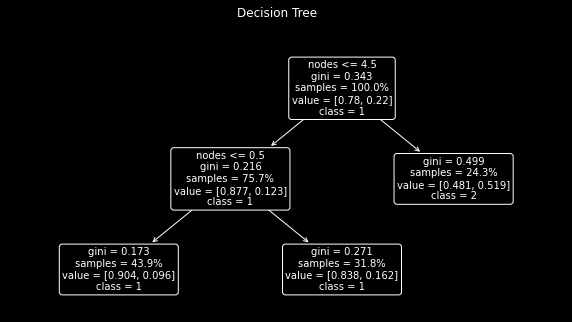

,metric,valueoriginal_model,valuebest_model
0,ACC,0.608696,0.630435
1,MCC,0.119594,0.160538
2,R,0.758621,0.793103
3,P,0.666667,0.676471
4,F,0.709677,0.730159


In [21]:
#compare the best model with the original one
def metric_comp(original,best):
    _items=original.items()
    _list=list(_items)
    df1=pd.DataFrame(_list,columns=['metric','value'])
    _items=best.items()
    _list=list(_items)
    df2=pd.DataFrame(_list,columns=['metric','value'])
    df_comp = df1.merge(df2, how='left', on='metric',suffixes=['original_model', 'best_model'])
    return df_comp

cart=DecisionTreeClassifier()
cart.fit(x_train.values,y_train.values)
y_pred_cart=cart.predict(x_test.values)

# Confusion matrix
CART_MC = confusion_matrix(y_test,y_pred_cart)

# Metrics
CART_METRICS = metric(y_test,y_pred_cart)
print(CART_METRICS)

# change parameters
np.random.seed(7)

max_depth = [2, 3, 5, 10, 20]
min_samples_leaf = [5, 10, 20, 50, 100]

criterion = ["gini", "entropy"]
param_grid = dict(max_depth=max_depth, min_samples_leaf=
min_samples_leaf,criterion=criterion)

grid_search = GridSearchCV(estimator=cart, param_grid=param_grid, cv
=n_folds, n_jobs=-1, verbose=1, scoring = "accuracy")

grid_result=grid_search.fit(x_train, y_train)
prof=grid_result.best_params_['max_depth']
min=grid_result.best_params_['min_samples_leaf']
crit=grid_result.best_params_['criterion']

# Remake the model
cart=DecisionTreeClassifier(max_depth=prof, min_samples_leaf=min,
criterion=crit)
cart.fit(x_train.values,y_train.values)
y_pred_cart_new=cart.predict(x_test.values)

# Confusion matrix
CART_MC_NEW = confusion_matrix(y_test,y_pred_cart_new)

# Metrics
CART_METRICS_NEW = metric(y_test,y_pred_cart_new)
print(CART_METRICS_NEW)
mc_heatmap(CART_MC, 'CART_MC', CART_MC_NEW)

# Plot decision tree
fig = plt.figure(figsize=(10,5))
fig.suptitle('Decision Tree')
tree.plot_tree(cart, feature_names=X.columns,filled=False,
class_names=['1','2'],fontsize=10,rounded=True, proportion=True)
plt.savefig(os.path.join(GRAPHS_PATH, 'cart_tree.png'))
plt.show()

metric_comp(CART_METRICS,CART_METRICS_NEW)

<h3>4 - KNN</h3>

{'ACC': 0.6413043478260869, 'MCC': 0.13428505920786402, 'R': 0.9137931034482759, 'P': 0.654320987654321, 'F': 0.7625899280575539}
{'ACC': 0.7065217391304348, 'MCC': 0.3542865778292613, 'R': 0.9827586206896551, 'P': 0.6867469879518072, 'F': 0.8085106382978723}


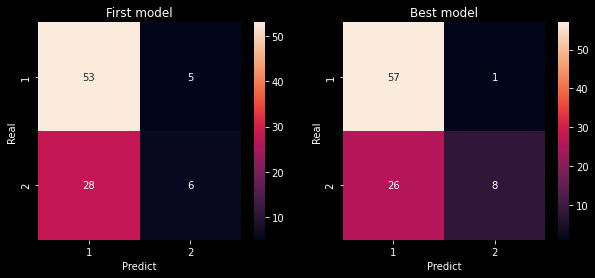

  metric  valueoriginal_model  valuebest_model
0    ACC             0.641304         0.706522
1    MCC             0.134285         0.354287
2      R             0.913793         0.982759
3      P             0.654321         0.686747
4      F             0.762590         0.808511


In [20]:

knn=KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train.values,y_train.values)
y_pred_knn=knn.predict(x_test.values)

# Confusion matrix
KNN_MC = confusion_matrix(y_test,y_pred_knn)
# Metrics
KNN_METRICS = metric(y_test,y_pred_knn)
print(KNN_METRICS)
#Best K
np.random.seed(7)

k = range(1,23,2)

deltaL = ['euclidean', 'minkowski', 'manhattan']
param_grid = dict(n_neighbors=k, metric=deltaL)

grid = GridSearchCV(estimator=knn, param_grid=param_grid, scoring=
scoring, cv=cv)

grid_result = grid.fit(x_train.values, y_train.values)
best_k=grid_result.best_params_['n_neighbors']
best_acc=grid_result.best_score_
best_dist=grid_result.best_params_['metric']

#Remake the model
knn=KNeighborsClassifier(n_neighbors=best_k,metric=best_dist)
knn.fit(x_train.values,y_train.values)
y_pred_knn=knn.predict(x_test.values)

#Confusion matrix
KNN_NEW_MC = confusion_matrix(y_test,y_pred_knn)

#New metrics
KNN_NEW_METRICS = metric(y_test,y_pred_knn)
print(KNN_NEW_METRICS)

#Print results
DIFF_KNN=metric_comp(KNN_METRICS,KNN_NEW_METRICS)
mc_heatmap(KNN_MC,'KNN_MC',KNN_NEW_MC)
print(DIFF_KNN)


<h3>5 - Naive Bayes (NB)</h3>

{'ACC': 0.6521739130434783, 'MCC': 0.1625794095374741, 'R': 0.9655172413793104, 'P': 0.6511627906976745, 'F': 0.7777777777777779}
Fitting 90 folds for each of 100 candidates, totalling 9000 fits


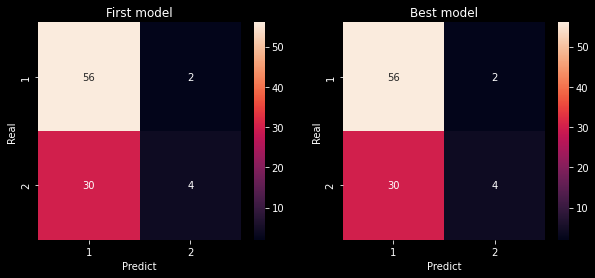

  metric  valueoriginal_model  valuebest_model
0    ACC             0.652174         0.652174
1    MCC             0.162579         0.162579
2      R             0.965517         0.965517
3      P             0.651163         0.651163
4      F             0.777778         0.777778


In [12]:
nb=GaussianNB()
nb.fit(x_train.values,y_train.values)
y_pred_nb=nb.predict(x_test.values)

#Confusion matrix
NB_MC = confusion_matrix(y_test,y_pred_nb)
#Metrics
NB_METRICS = metric(y_test,y_pred_nb)
print(NB_METRICS)

#Tunning the model
np.random.seed(7)
var_smoothing = np.logspace(0,-9, num=100)
param_grid = dict(var_smoothing=var_smoothing)
grid_search = GridSearchCV(estimator=nb, param_grid=param_grid, cv=cv,
n_jobs=-1, verbose=1, scoring=scoring)
grid_result=grid_search.fit(x_train, y_train)
var=grid_result.best_params_['var_smoothing']

#Remake the model
nb=GaussianNB(var_smoothing=var)
nb.fit(x_train.values,y_train.values)
y_pred_new_nb=nb.predict(x_test.values)

#New confusion matrix
NB_NEW_MC = confusion_matrix(y_test,y_pred_new_nb)
#New metrics
NB_NEW_METRICS = metric(y_test,y_pred_new_nb)

#plot results
DIFF_NB=metric_comp(NB_METRICS,NB_NEW_METRICS)
mc_heatmap(NB_MC,'NB_MC',NB_NEW_MC)
print(DIFF_NB)
